## 추세 지표에 따른 투자
* 추세 : 주가가 진행하는 방향
* 모멘텀, 방향성지수, 엔빌롭 등등..

In [1]:
import os
import pandas as pd
from tqdm import tqdm

sp_data_dict = dict()
for file_name in tqdm(os.listdir("data/주가데이터")):
    sp_data = pd.read_csv("data/주가데이터/" + file_name, parse_dates = ['Date'])
    stock_name = file_name.replace('.csv', '')
    sp_data_dict[stock_name] = sp_data

100%|██████████| 2170/2170 [00:19<00:00, 111.19it/s]


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
sns.set()
%matplotlib inline
rcParams['font.family'] = 'Malgun Gothic'
rcParams['axes.unicode_minus'] = False

## 모멘텀
* 시장의 과매입 혹은 과매도 상태를 나타내는 지표. 일정 기간 동안의 주가 상승 및 하락을 알려주는 기초 추세 지표
* 모멘텀_n = (금일 종가 - n 영업일 전 종가) / n영업일 전 종가 * 100 (%)
* 모멘텀이 양ㅅ이면 현재 상승 추세에 있다고 판단하여 매수. 반대일때 매도


In [4]:
import numpy as np

mom_data = pd.DataFrame()
for stock_name in tqdm(sp_data_dict.keys()):
    sp_data = sp_data_dict[stock_name]
    sp = sp_data["Close"].values

    # 모멘텀 계산
    # 모멘텀은 단기 추세 지표이므로 5, 10, 20일 생성
    mom_5 = (sp[5:] - sp[:-5]) / sp[:-5] * 100
    mom_10 = (sp[10:] - sp[:-10]) / sp[:-10] * 100
    mom_20 = (sp[20:] - sp[:-20]) / sp[:-20] * 100
    mom_5 = np.insert(mom_5, [0] * 5, np.nan)
    mom_10 = np.insert(mom_10, [0] * 10, np.nan)
    mom_20 = np.insert(mom_20, [0] * 20, np.nan)

    # 모멘텀 변수 추가
    temp = pd.DataFrame({"Date":sp_data['Date'].values})
    temp["모멘텀_5"] = mom_5
    temp["모멘텀_10"] = mom_10
    temp["모멘텀_20"] = mom_20

    # 수익률 추가
    ror_5 = np.insert(mom_5, [-1] * 5, np.nan)[5:]
    ror_10 = np.insert(mom_10, [-1] * 10, np.nan)[10:]
    ror_20 = np.insert(mom_20, [-1] * 20, np.nan)[20:]
    temp["수익률_5"] = ror_5
    temp["수익률_10"] = ror_10
    temp["수익률_20"] = ror_20

    temp.dropna(inplace = True)
    mom_data = pd.concat([mom_data, temp], axis = 0, ignore_index = True)

100%|██████████| 2170/2170 [01:45<00:00, 20.66it/s]


In [5]:
# 리밸런싱

result = []
date_list = sorted(mom_data["Date"].unique())
for date in tqdm(date_list):
    temp = mom_data.loc[mom_data['Date'] == date]
    for n in [5, 10, 20]:
        # 모멘텀 정도에 따라 0 ~ 4까지의 그룹으로 분류. 그룹 0이 가장 낮은 모멘텀을 가지는 그룹
        temp["그룹"] = pd.qcut(temp['모멘텀_' + str(n)], 5,labels = range(5)).astype(int)

        for group in range(5):
            ror_list = temp.loc[temp["그룹"] == group, "수익률_" + str(n)].values
            inve_per_stock = 10 ** 8 / sum(temp["그룹"] == group)
            profit = (inve_per_stock * ror_list / 100).sum()
            profit_ratio = profit / 10 ** 8 * 100
            result.append([n, group, profit_ratio])

result = pd.DataFrame(result, columns = ["영업일", "그룹", "수익률"])

100%|██████████| 2608/2608 [01:17<00:00, 33.63it/s]


<AxesSubplot:xlabel='영업일,그룹'>

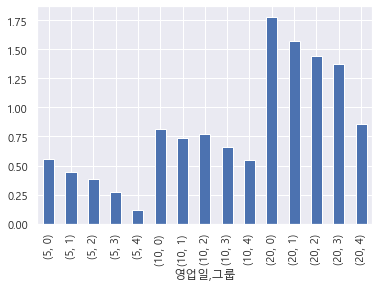

In [6]:
result.groupby(['영업일', '그룹'])['수익률'].mean().round(2).plot(kind = 'bar')

# 모멘텀이 가장 적은 0이 가장 높은 수익률을 보이고, 순서대로 낮아짐
# 모든 그룹에서 0 이상의 수익률을 보임!

<AxesSubplot:xlabel='영업일,그룹'>

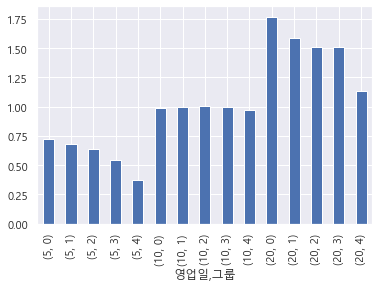

In [7]:
result.groupby(['영업일', '그룹'])['수익률'].median().round(2).plot(kind = 'bar')

# 10 영업일을 제외하고 중위수도 비슷한 형태를 보임
# 이는 인식과 다르게 모멘텀이 낮은 그룹에 투자하는것이 좋은것을 의미

In [8]:
print(result.groupby(['영업일', '그룹'])['수익률'].describe().round(2))

# 대부분의 지표에서 그룹 0이 가장 높음. 그러나 최소값과 1사분위수도 가장 낮음
# 이는 수익과 손실 모두 크다는 것을 의미함. 그럼에도 평균값이 가장 높기 때문에 그룹 0에 투자하는것이 더 좋음

         count  mean   std    min   25%   50%   75%    max
영업일 그룹                                                    
5   0   2608.0  0.56  3.73 -33.55 -1.20  0.72  2.43  36.06
    1   2608.0  0.44  3.21 -30.06 -0.95  0.68  2.00  29.11
    2   2608.0  0.38  2.91 -29.21 -0.90  0.64  1.86  24.51
    3   2608.0  0.27  2.74 -24.76 -0.90  0.54  1.75  19.94
    4   2608.0  0.12  2.83 -20.79 -1.28  0.37  1.84  14.10
10  0   2608.0  0.81  5.27 -42.37 -1.91  0.99  3.50  58.36
    1   2608.0  0.74  4.52 -41.07 -1.45  1.00  3.00  46.67
    2   2608.0  0.77  4.13 -37.58 -1.21  1.01  2.97  39.12
    3   2608.0  0.66  3.84 -32.61 -1.25  1.00  2.85  29.38
    4   2608.0  0.55  4.01 -27.55 -1.70  0.97  3.07  19.07
20  0   2608.0  1.78  7.37 -42.76 -2.28  1.77  5.73  78.75
    1   2608.0  1.57  6.42 -39.66 -1.72  1.59  5.06  65.12
    2   2608.0  1.44  5.84 -39.25 -1.48  1.51  4.55  52.55
    3   2608.0  1.37  5.45 -33.69 -1.47  1.51  4.46  43.98
    4   2608.0  0.86  5.85 -40.76 -2.68  1.13  4.52  23.